In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns; sns.set()
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from pandas.util import hash_pandas_object

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
#Uncomment next line when u first use nltk and press download when all in selected on the windows of nltk downloads
#nltk.download()

from ast import literal_eval

#To detect language for stemming
# https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes
from langdetect import detect

## Import data

In [2]:
raw_data = pd.read_csv('../data/en.openfoodfacts.org.products.csv', sep = '\t')

C:\Users\Yann Schilling\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Drop columns not needed, explore missing values, and delete rows with zero or one value present

In [3]:
columns2keep = ['energy_100g','sugars_100g','saturated-fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g','fiber_100g','proteins_100g','nutrition-score-uk_100g',
    'nutrition_grade_fr','main_category_en','packaging','categories','labels_en',
    'pnns_groups_1','pnns_groups_2','product_name','ingredients_text','nutrition_grade_fr']

In [4]:
data = raw_data[columns2keep]

In [5]:
data = data.replace("unknown",np.nan)

In [6]:
data = data.loc[(~data.isnull()).sum(axis=1)>1]

# FOOD CATEGORIES

In our first step, we aim to categorize products according to their Food Category. The PNNS ("Programme national nutrition santé" in French) aims at categorizing food in several major classes: Dairies, Composite, Fish Meat Eggs, Beverages, Fat Sauces, Fruits Vegetables, Starchy, and Snacks.

https://www.cerin.org/rapports/groupes-groupes-daliments/

### From pnns_groups_1 column

We map the given pnns categories to our 8 major ones

In [444]:
data["pnns_groups_1"].value_counts()

Sugary snacks              58626
Milk and dairy products    43945
Fish Meat Eggs             43040
Cereals and potatoes       34562
Beverages                  29319
Fat and sauces             28375
Composite foods            25712
Fruits and vegetables      24710
Salty snacks               19978
sugary-snacks               3498
fruits-and-vegetables       2924
cereals-and-potatoes          44
salty-snacks                   5
Name: pnns_groups_1, dtype: int64

In [445]:
# dictionnary to normalize category names into PNNS category
pnns1_category = {
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Dairies',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}
data.loc[:,'food_category'] = data['pnns_groups_1'].map(pnns1_category)

In [446]:
# New pnns categories
data["food_category"].value_counts()

Snacks               82107
Dairies              43945
Fish Meat Eggs       43040
Starchy              34606
Beverages            29319
Fat Sauces           28375
Fruits Vegetables    27634
Composite            25712
Name: food_category, dtype: int64

### From pnns_groups_2 column

We notice that several products haven't been categorized but have a non missing value in pnns_groups_2

In [447]:
# Values of pnns_groups_2 which haven't been classified in food_category
data.loc[data.food_category.isnull()]["pnns_groups_2"].value_counts()

Alcoholic beverages       10460
Pizza pies and quiches      402
Name: pnns_groups_2, dtype: int64

In [448]:
# dictionnary to extend food_categories from pnns_groups_2
pnns2_category = {
 'Pizza pies and quiches' : 'Composite', 
 'Alcoholic beverages' : 'Beverages',
}
data.loc[data.food_category.isnull(),'food_category'] = data.loc[data.food_category.isnull()]['pnns_groups_2'].map(pnns2_category)

In [449]:
data["food_category"].value_counts()

Snacks               82107
Dairies              43945
Fish Meat Eggs       43040
Beverages            39779
Starchy              34606
Fat Sauces           28375
Fruits Vegetables    27634
Composite            26114
Name: food_category, dtype: int64

### From main_category_en column

We complete our categorization with the help of the 'main_category_en' column

In [450]:
data.loc[data.food_category.isnull()]["main_category_en"].value_counts().head(30)

Beverages                          9485
Groceries                          6052
Plant-based foods and beverages    5362
Snacks                             3535
Dietary supplements                2032
Dairies                            1578
Desserts                           1300
Sweeteners                         1248
Baby foods                         1242
Cooking helpers                     743
Crêpes and galettes                 689
Food additives                      595
Non food products                   521
Canned foods                        480
Frozen foods                        452
Spreads                             398
Cocoa and chocolate powders         332
Licensed products                   306
Syrups                              288
Chips and fries                     267
es:bolleria-industrial              237
fr:bloc-de-foie-gras-de-canard      229
Pizza dough                         204
Breakfasts                          198
Banana-crisps                       197


In [451]:
# After inspecting the food type for the 30 most frequent values in main_category_en, we create the following dictionary
maincategoryen_category = {
'Beverages' : 'Beverages',
'Snacks' : 'Snacks',
'Dairies' : 'Dairies',
'Desserts' : 'Dairies',
'Crêpes and galettes' : 'Snacks',
'Cocoa and chocolate powders': 'Snacks',
'Syrups':'Fat Sauces',
'Chips and fries': 'Snacks',
'es:bolleria-industrial': 'Snacks',
'fr:bloc-de-foie-gras-de-canard': 'Fish Meat Eggs' ,
'Pizza dough' : 'Starchy',
'Breakfast' : 'Starchy',
'Banana-crisps' : "Snacks",
'Fish eggs' : 'Fish Meat Eggs',
'Terrines' : 'Fish Meat Eggs',
'fr:escalopes' : 'Fish Meat Eggs',
'Salads' : 'Fruits Vegetables',
'fr:pilons-de-poulet' : 'Fish Meat Eggs'
}

data.loc[data.food_category.isnull(),'food_category'] =  data.loc[data.food_category.isnull(),'main_category_en'].map(maincategoryen_category)

In [452]:
sum(data["food_category"].value_counts())/len(data)

0.37547936119300895

**After these steps, we managed to categorize 37% of our date among PNNS groups.**

For the unclassified data, the other columns don't bring any strong evidence for the categorization of the product. For instance, a lot of Dietary Supplements or Non Food Products are unclassified. Also, the table beneath shows that no column with above 10% completeness for uncategorized data gives us direct information on food categories.

In [460]:
completeness = raw_data.iloc[data[data.food_category.isnull()].index].count().sort_values(ascending=False)/len(data.loc[data.food_category.isnull()])
completeness.loc[completeness>0.1]

code                                       1.000000
states_en                                  1.000000
pnns_groups_1                              1.000000
pnns_groups_2                              1.000000
states                                     1.000000
states_tags                                1.000000
last_modified_datetime                     1.000000
last_modified_t                            1.000000
created_datetime                           1.000000
created_t                                  1.000000
creator                                    1.000000
url                                        1.000000
countries                                  0.998790
countries_en                               0.998790
countries_tags                             0.998790
product_name                               0.994166
energy_100g                                0.940412
proteins_100g                              0.937662
carbohydrates_100g                         0.935462
fat_100g    

In [461]:
classified_data = data.loc[~data.food_category.isnull()]
unclassified_data = data.loc[data.food_category.isnull()]

In [462]:
classified_data.loc[~classified_data.ingredients_text.isnull(),"ingredients_text"].count()/len(classified_data)

0.62757508426493713

40% of the remaining data has a list of ingredients, and 62% of our classified data also has a list of ingredients. We will use word similarities on the words in ingredient_text to associate unclassified products to categories if the similarity is big enough.

### Using Ingredients_text column 

In [463]:
# We clean the list of ingredients by removing punctuation and numbers

def clean_text(df,col):
    
    caracters2delete = ['%','-',':',',',"  ",'(',')',';','/','_','*','\d+','.','\'','[',']']

    df.loc[:,col] = df.loc[:,col].str.lower()
    for c in caracters2delete:
        df.loc[:,col] = df.loc[:,col].str.replace(c,' ')

    

clean_text(classified_data,"ingredients_text")
clean_text(unclassified_data,"ingredients_text")

/Users/romain/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [464]:
# We compute the set of words for each category by keeping the 100 most frequent words that aren't stopWords

from collections import Counter
import nltk
from nltk.corpus import stopwords

# The dominant language in the ingredients in french
stopWords = stopwords.words('french') + ["kg","g","v","a","b","k","e","mg","and","of","ml","cl"]

def jaccard_similarity(list1, list2):
    s1 = set(list1) # gives the keys
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

def createWordSet(df):   
    count = Counter([ word for sentence in df.loc[~df["ingredients_text"].isnull(),"ingredients_text"].tolist() for word in sentence.split(" ")[:5] if word not in stopWords])
    count[""] = 0
    n = sum(count.values())
    return dict([(word[0],word[1]/n) for word in count.most_common(100)])

category_words = classified_data.groupby("food_category").apply(createWordSet)
category_words["Beverages"]

{'acid': 0.003435459568056253,
 'acide': 0.0046207935710698145,
 'acidifiant': 0.005685585133098945,
 'agua': 0.010226017076845806,
 'alcool': 0.001988950276243094,
 'aloe': 0.0020291310899045708,
 'ananas': 0.002621798091411351,
 'apfelsaft': 0.0022199899547965846,
 'apple': 0.0035158211953792064,
 'arabica': 0.0022702159718734306,
 'arôme': 0.004972375690607734,
 'arômes': 0.0015770969362129583,
 'aus': 0.0029834254143646407,
 'barley': 0.0019085886489201406,
 'base': 0.009844299347061778,
 'bio': 0.0033550979407333,
 'bière': 0.0016273229532898041,
 'black': 0.002360622802611753,
 'blanc': 0.0023304871923656456,
 'boisson': 0.002380713209442491,
 'cacao': 0.0020090406830738324,
 'café': 0.006991461577096936,
 'cane': 0.001747865394274234,
 'canne': 0.0037769964841788046,
 'caramel': 0.003053741838272225,
 'carbonatada': 0.0016273229532898041,
 'carbonated': 0.006559517830236062,
 'citric': 0.0030939226519337017,
 'citrique': 0.0016474133601205425,
 'citron': 0.003566047212456052,
 '

The example shown above is the word dictionary for 'Beverages'. For each category we obtain a dictionary of the 100 most frequent words with normalized counts.

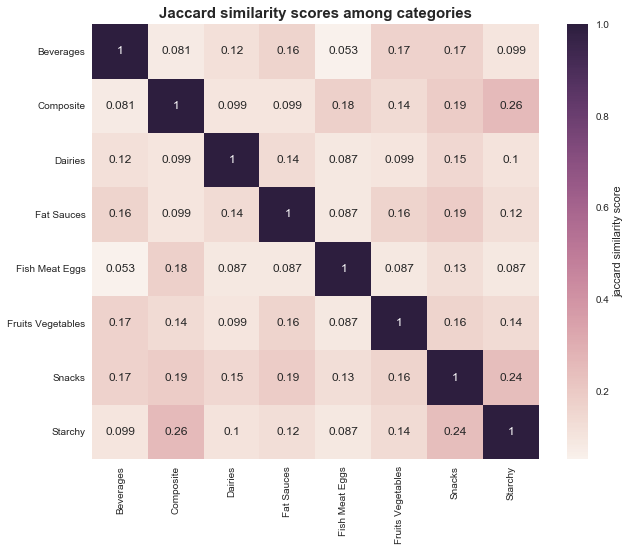

In [465]:
columns = category_words.index.values
n = len(columns)
similarity_matrix = np.zeros((n,n))

for idx1,name1 in enumerate(columns):
    for idx2,name2 in enumerate(columns):
        similarity_matrix[idx1,idx2] = jaccard_similarity(category_words[name1],category_words[name2])

plt.figure(figsize=(10,8))
sns.heatmap(similarity_matrix, annot=True, cbar_kws={'label': 'jaccard similarity score'})
plt.title("Jaccard similarity scores among categories", fontsize=15, fontweight="bold")
plt.xticks(np.arange(n)+0.5,columns,rotation='vertical')
plt.yticks(np.arange(n)+0.5,np.flip(columns,axis=0),rotation='horizontal')
plt.show()

We see that the dictionaries are rather distinct. The 'Composite' category shares words with other categories since it groups products from different food categories. We decide to drop 'Composite' for further categorization as it is too subjective to associate multiple categories to products with only the list of ingredients. We obtain more accurate results by associating only one category to products if the similarity is above an experimentally-set threshold.

In [466]:
category_words = category_words.drop("Composite")

In [467]:
# We split the unclassified data ingredient list in a list of non-stop words 

unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'] = \
    unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'] \
    .apply(lambda x: [word for word in x.split() if word not in stopWords])

/Users/romain/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


To compute the similarity between a list of ingredients and a category, we compute a score. Each word in the list adds to the category score its importance in the category dictionary (normalized count in the dictionary) which is also weighted by its position in the ingredients list. The idea the ingredients of a product are listed in order of importance. We only consider the 10 first words in the ingredient list. We also divide the word score by the number of dictionaries it which it occurs. The ingredient is less representative of a food category if it also represents other categories.

We then categorize a product if its maximum similarity is above a 0.3 threshold. This threshold was set experimentally by manually looking up a product's information with its computed category.

In [468]:
intersections = dict();
for col in category_words.index.values:
    for word in set(category_words[col]):
        intersections[word] = intersections.get(word,0)+1


def similarity_dic(ingredients):
    dic = {}
    n = 10        
    for cat in category_words.index.values:
        score = 0
        for idx,word in enumerate(ingredients[:n]):
            score += category_words[cat].get(word,0)*(n-idx)/intersections.get(word,1)
        dic[cat] = score
    total = sum(dic.values())
    if (total != 0) :
        dic = {k: v / total for k, v in dic.items()}
    return dic

similarities = unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),"ingredients_text"] \
            .apply(similarity_dic).apply(pd.Series)
    
# We remove products that have no similarities
similarities = similarities[(similarities.T != 0).any()]

similarities["category"] = similarities.loc[similarities.max(axis=1)>0.3].idxmax(axis=1)

# List some results with product_names
pd.concat([similarities,data.loc[similarities.index,"product_name"]], axis=1).head(20)

,Beverages,Dairies,Fat Sauces,Fish Meat Eggs,Fruits Vegetables,Snacks,Starchy,category,product_name
15,0.310519,0.080830,0.169091,0.314559,0.106957,0.013327,0.004717,Fish Meat Eggs,Solène céréales poulet
22,0.061070,0.613197,0.029398,0.001845,0.032853,0.229880,0.031756,Dairies,Crème dessert chocolat
29,0.083283,0.015092,0.055804,0.023001,0.037040,0.344211,0.441569,Starchy,Baguette Poitevin
38,0.057656,0.009967,0.045508,0.009508,0.032706,0.388776,0.455879,Starchy,Suedois saumon
43,0.141383,0.042021,0.291048,0.098668,0.325453,0.080292,0.021135,Fruits Vegetables,Salade shaker taboulé
44,0.078995,0.005559,0.442263,0.024881,0.054371,0.346683,0.047247,Fat Sauces,Banana Chips Sweetened (Whole)
45,0.014486,0.018899,0.032111,0.018949,0.022410,0.230830,0.662315,Starchy,Peanuts
49,0.145843,0.503958,0.088943,0.020304,0.040916,0.180696,0.019342,Dairies,Fromage blanc à la creme de marron
54,0.000000,0.000000,0.004397,0.000000,0.000000,0.451589,0.544013,Starchy,Sandwich solene céréales sicilien
96,0.079838,0.113494,0.281367,0.001625,0.164477,0.172896,0.186302,NaN,Organic Salted Nut Mix


We see that the categorization yields good results. Some products stay uncategorized by lack of dominant similarity but those who are appear to be well categorized with small errors (ex: Banana Chips Sweetened in row 44)

In [469]:
# We assign the new categroy values to those with missing categories
data.loc[data.food_category.isnull(),"food_category"] = similarities["category"]

sum(data["food_category"].value_counts())/len(data)

0.58575568889145446

The new number of categorized products represents 57% of the data kept.

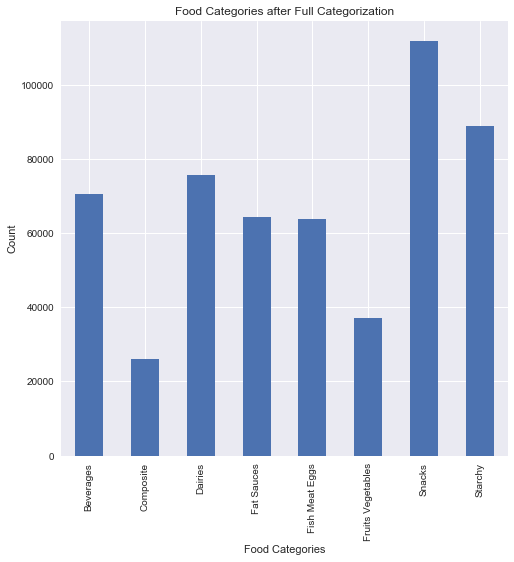

In [470]:
plt.figure(figsize=(8,8))
data.groupby("food_category").size().plot.bar()
plt.xlabel("Food Categories");
plt.ylabel("Count");
plt.title("Food Categories after Full Categorization");

# PACKAGING

While this field remains incomplete, it is still useful for us to analyze the packaging methods of different food categories. The processing pipeline for this field was performed as follows :
- clean 'Packaging' column of the dataframe by removing stop words and unecessary entries
- retain only certain material types of packaging (plastic, glass, cardboard, metal ...)
- plot the proportion of each material within a certain category of food

In [554]:
# We build our list of stopwords to remove when tockenizing the packaging column
stop_words_c = set(stopwords.words("french")).union(set(stopwords.words("english")))

# 'can' was removed since it was in the stop words list but still useful for Beverages containers
stop_words_c.remove('can')

In [562]:
# We clean the packaging column
def clean_data_packaging(data_column):
    """Clean data packaging, i.e. 
        - lower each words in the cells of data_column
        - tokenize cells of data_column, i.e. from float type create list of string (token)
        - remove stopwords for the list of tokens for each cells of data_column
    """  
    
    tokenizer = RegexpTokenizer(r'\w+')
    data_column = data_column[data_column.notnull()].str.lower() \
    .apply(str) \
    .apply(tokenizer.tokenize) \
    .apply(lambda cell : [item for item in cell if item not in stop_words_c]) \
    .apply(str)
    
    return data_column


packaging = clean_data_packaging(data.packaging)
packaging = packaging.apply(literal_eval)
filled_pck = data.packaging.count()/len(data.packaging)

# We visualize some results
print(f'Packaging field is full at {filled_pck} %')
packaging.head()

Packaging field is full at 0.20338202187226692 %


16     [barquette, plastique]
141        [bocal, plastique]
145               [plastique]
299       [carton, plastique]
300       [plastique, carton]
Name: packaging, dtype: object

**20% of the data has packaging information**
We now categorize the packaging information to defined packaging classes.

In [577]:
# Vaccum items were added since it surely contains plastic
plastique_words = ['plastic', 'plastique', 'plastik', 'plastico', 'plastica', 'sachets', 
                   'plàstic', 'plástico', 'plastisco' ,'bucket', 'barquette', 'sachet', 'tube', 'film', 'vacio', 'vide', 'vacío']

verre_words = ['verre', 'glass', 'glas', 'vidrio', 'pot']
carton_words = ['paper', 'karton', 'carton', 'papier', 'boite', 'cartón', 'papel', 'cardboard', 
                'card', 'eggbox', 'box']

metal_words = ['metal', 'métal', 'fer', 'acier', 'aluminium', 'can', 'canette', 'conserve','tin']

# Fresh products needs an adapted container which is useful for further exploration
prod_frais_words = ['frais', 'fresh', 'frai']

# The recycable materials depend on the country and regulations. However, these materials are commonly recycable.
# (soiled papers, soiled metalic containers and soiled plastic containers tend to be avoided for medical reasons)
recyclable_words = ['bouteille', 'flacon', 'brique', 'brick', 'bottle', 'bte', 'verre', 
                    'glass', 'glas', 'vidrio', 'metal', 'métal', 'fer', 'acier', 'aluminium', 'flasche', 'canned', 
                    'can', 'canette', 'conserve', 'tin', 'pet', 'pot', 'botella']

def count_entries(self, word_list):
    """ Return true if word_list and self have a word in common,
        else o/w.
    """
    if len(set(self).intersection(set(word_list))) > 0:
        return True
    else :
        return False

def to_materials(elem):
    """ Return a list of bool that informs about the materials used 
        for the packaging.
    """
    return [count_entries(elem, plastique_words), 
               count_entries(elem, verre_words), 
               count_entries(elem, carton_words),
               count_entries(elem, metal_words),
               count_entries(elem, prod_frais_words),
               count_entries(elem, recyclable_words)]
    

In [595]:
# We a create a boolean list for each value representing the membership to packaging methods and fresh/recycable attribute
materials_df = pd.DataFrame({'Packaging': packaging, 'materials':pd.Series(np.zeros(len(packaging)), packaging.index)})
materials_df['materials'] = packaging.apply(to_materials)

In [596]:
# We create a dataframe with the information
names = ['Plastic', 'Glass', 'Carton', 'Metal', 'Fresh', 'Recyclable']
materials_df = materials_df.materials.apply(pd.Series)
materials_df = materials_df.rename(columns = lambda x : names_list[x])

In [597]:
# We merge with the food categories
eco_impact_plot_df = materials_df.merge(data.loc[materials_df.index.tolist(), ["food_category"]], left_index = True, right_index = True)

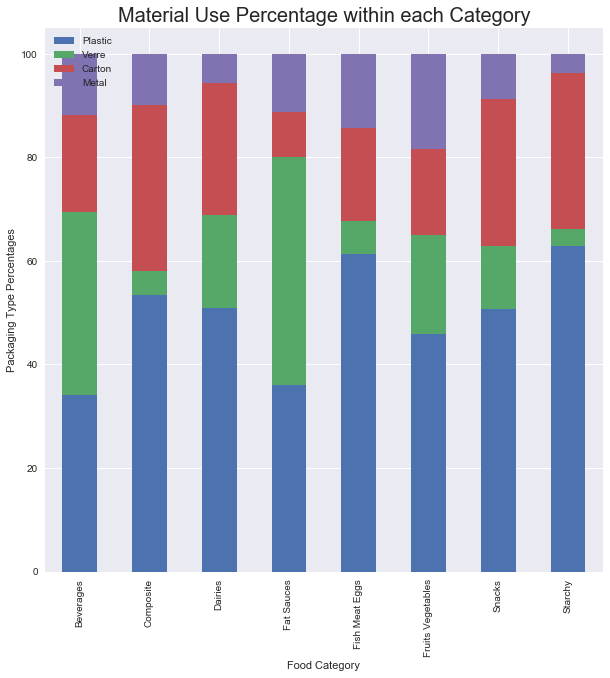

In [603]:
# We remove Fresh and Recycable categories and plot normalized bar plots for the packaging for each food category
packaging_plot_df = eco_impact_plot_df.drop('Frais', axis =1)
packaging_plot_df = packaging_plot_df.drop('Recyclable', axis =1)
counts_pack = packaging_plot_df.groupby('food_category').sum()

plt.figure(figsize =(10,10))
ax=plt.gca()
counts_pack.div(counts_pack.sum(axis=1)/100, axis = 0).plot.bar(ax=ax, stacked=True)
plt.title('Material Use Percentage within each Category',fontsize=20);
plt.xlabel("Food Category");
plt.ylabel("Packaging Type Percentages");

While the sample size is limited, a few useful informations are depicted on the above plot. First we can see that a lot of plastic is used among every category. Moreover, glass is mainly used as a liquid container which is consistent with what we could expect. The packaging information along with the use of cooling containers and recyclability of products will be used in the analysis of different diets.

# NUTRISCORE
https://quoidansmonassiette.fr/comment-est-calcule-le-nutri-score-logo-nutritionnel/

We calculate the nutriscore according to the method described in the link above.

### Water Tag
In order to compute the NutriScore (NS) of products, we need to seperate water from other beverages.

In [487]:
# Words which reference water
water_list = ["water","waters","eau","agua"]

# Some 'categories' values contain words refering to water but are liquors
# We thus create a list to discard such products
nonwater_list = ["alkoholische","alcoholic","spirits","liquors"]

# We clean the 'categories' column and split into words
data["split_categories"] = data["categories"]
clean_text(data,"split_categories")
data.loc[:,"split_categories"] = data.loc[:,"split_categories"].str.split()

data["iswater"] = data.loc[~data["split_categories"].isnull(),"split_categories"] \
.apply(lambda l : bool(~any([cat_word in nonwater_list for cat_word in l]) &  \
                       any([cat_word in water_list for cat_word in l])))




In [488]:
data["iswater"].value_counts()

False    386517
True       1111
Name: iswater, dtype: int64

### Data Setup

In [502]:
# replace NaN of 'fruits-vegetables-nuts_100g' by 100 if it is 'Fruit juices'
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(100, inplace=True)

In [503]:
selected_fields =[
    'food_category',
    'energy_100g','sugars_100g','saturated-fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g',
    'fiber_100g','proteins_100g',
    'nutrition-score-uk_100g','nutrition_grade_fr',
    'iswater'
]

In [504]:
# divide dataframe into 3 groups to simplify the calculation of nutriscrore
data_beverages = data[data['food_category']=='Beverages'][selected_fields]
data_fatsauces = data[data['food_category']=='Fat Sauces'][selected_fields]
data_without_beverage_fat = data[(data['food_category']!='Fat Sauces') & (data['food_category']!='Beverages') ][selected_fields]                    

### Calculation of negative points

We attribute Negative points (N) to different nutritional factors that have to be limited: energy, sugar, saturated fat and sodium

In [505]:
## ENERGY
# energy bins
energy_bins_without_beverage_fat = [data_without_beverage_fat['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_without_beverage_fat['energy_100g'].max()]
energy_bins_fatsauces = [data_fatsauces['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_fatsauces['energy_100g'].max()]
energy_bins_beverages = [data_beverages['energy_100g'].min() - 1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, data_beverages['energy_100g'].max()]
# energy point
data_without_beverage_fat['energy_points'] = pd.cut(data_without_beverage_fat['energy_100g'], energy_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['energy_points'] = pd.cut(data_fatsauces['energy_100g'], energy_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['energy_points'] = pd.cut(data_beverages['energy_100g'], energy_bins_beverages, labels=range(11)).astype(float)


## SUGAR
# sugar bins
sugar_bins_without_beverage_fat = [data_without_beverage_fat['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_without_beverage_fat['sugars_100g'].max()]
sugar_bins_fatsauces = [data_fatsauces['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_fatsauces['sugars_100g'].max()]
sugar_bins_beverages = [data_beverages['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data_beverages['sugars_100g'].max()]
# sugar point (CHANGE SUGAR_BINS)
data_without_beverage_fat['sugar_points'] = pd.cut(data_without_beverage_fat['sugars_100g'], sugar_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['sugar_points'] = pd.cut(data_fatsauces['sugars_100g'], sugar_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['sugar_points'] = pd.cut(data_beverages['sugars_100g'], sugar_bins_beverages, labels=range(11)).astype(float)


## SATURATED FAT
# s-fat bins
fat_bins_without_beverage_fat = [data_without_beverage_fat['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_without_beverage_fat['saturated-fat_100g'].max()]
fat_bins_beverages = [data_beverages['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_beverages['saturated-fat_100g'].max()]
fat_bins_fatsauces = [data_fatsauces['saturated-fat_100g'].min() - 1, 10, 16, 22, 28, 34, 40, 46, 52, 58, 64, data_fatsauces['saturated-fat_100g'].max()]
# s-FAT point (CHANGE FAT_BINS)
data_without_beverage_fat['saturated-fat_points'] = pd.cut(data_without_beverage_fat['saturated-fat_100g'], fat_bins_without_beverage_fat, labels=range(11)).astype(float)
data_beverages['saturated-fat_points'] = pd.cut(data_beverages['saturated-fat_100g'], fat_bins_beverages, labels=range(11)).astype(float)
data_fatsauces['saturated-fat_points'] = pd.cut(data_fatsauces['saturated-fat_100g'], fat_bins_fatsauces, labels=range(11)).astype(float)


## SODIUM
# sodium bins
sodium_bins = [data['sodium_100g'].min() - 1, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
# sodium points
data_without_beverage_fat['sodium_points'] = pd.cut(data_without_beverage_fat['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_beverages['sodium_points'] = pd.cut(data_beverages['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_fatsauces['sodium_points'] = pd.cut(data_fatsauces['sodium_100g'], sodium_bins, labels=range(11)).astype(float)



### Calculation positive points

We attribute Positive points (P) to different nutritional factors that have to be promoted: fruit vegetable nuts pourcentage, fibers and proteins.

In [506]:
# FRUITS
# fruits bins
fruits_bins_without_beverage_fat = [data_without_beverage_fat['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_without_beverage_fat['fruits-vegetables-nuts_100g'].max()]
fruits_bins_fatsauces = [data_fatsauces['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_fatsauces['fruits-vegetables-nuts_100g'].max()]
fruits_bins_beverages = [data_beverages['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_beverages['fruits-vegetables-nuts_100g'].max()]
# fruits points
data_without_beverage_fat['fruits_points'] = pd.cut(data_without_beverage_fat['fruits-vegetables-nuts_100g'], fruits_bins_without_beverage_fat, labels=[0,1,2,5]).astype(float)
data_beverages['fruits_points'] = pd.cut(data_beverages['fruits-vegetables-nuts_100g'], fruits_bins_beverages, labels=[0,2,4,10]).astype(float)
data_fatsauces['fruits_points'] = pd.cut(data_fatsauces['fruits-vegetables-nuts_100g'], fruits_bins_fatsauces, labels=[0,1,2,5]).astype(float)


# FIBRES
# fibers bins
fibers_bins = [data['fiber_100g'].min() - 1, 0.7, 1.4, 2.1, 2.8, 3.5, data['fiber_100g'].max()]
# fibers points
data_without_beverage_fat['fiber_points'] = pd.cut(data_without_beverage_fat['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_beverages['fiber_points'] = pd.cut(data_beverages['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_fatsauces['fiber_points'] = pd.cut(data_fatsauces['fiber_100g'], fibers_bins, labels=range(6)).astype(float)

# PROTEINS
# proteins bins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
# proteins points
data_without_beverage_fat['proteins_points'] = pd.cut(data_without_beverage_fat['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_beverages['proteins_points'] = pd.cut(data_beverages['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_fatsauces['proteins_points'] = pd.cut(data_fatsauces['proteins_100g'], proteins_bins, labels=range(6)).astype(float)


In [507]:
# rejoin last separated dataframe
frames = [data_without_beverage_fat, data_beverages, data_fatsauces]
nutridata = pd.concat(frames)

### Nutriscore calculation

In [537]:
# concession made to put 0 inplace of Nan of 'fruits_points','fiber_points','proteins_points' 
# this will not be a problem we do not substract Positive point
nutridata['fruits_points'] = nutridata['fruits_points'].fillna(0)
nutridata['fiber_points'] = nutridata['fiber_points'].fillna(0)
nutridata['proteins_points'] = nutridata['proteins_points'].fillna(0)

In [538]:
# calculation of P x N
nutridata['points_N']= nutridata['energy_points'] + nutridata['saturated-fat_points'] + nutridata['sugar_points'] + nutridata['sodium_points']
nutridata['points_P'] = nutridata['fruits_points'] + nutridata['fiber_points'] + nutridata['proteins_points']

In [539]:
def compute_score(row):
    N = row['points_N']
    P = row['points_P']
    fruit = row['fruits_points']
    fiber = row['fiber_points']
        
    if N < 11 or fruit == 5:
        return N - P
    else:
        return N - (fiber + fruit)
    
nutridata['nutri-score_calculated'] = nutridata.apply(compute_score, axis=1)

### Convertion of NutriScore into NutriLetter


In [541]:
# re divided dataframe to allow a simpler transformation of score into letter
nutridata_beverages = nutridata[ (nutridata['food_category']=='Beverages') & (nutridata['iswater']!=True)]
nutridata_not_beverages = nutridata[ nutridata['food_category']!='Beverages']
nutridata_beverages_water = nutridata[ (nutridata['food_category']=='Beverages') & (nutridata['iswater']==True)]

In [543]:
# NUTRILETTER

#letter bins
letter_bins_aliments = [nutridata['nutri-score_calculated'].min() - 1, 0, 2.9, 10.9, 18.9, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages = [nutridata['nutri-score_calculated'].min() - 1, 2.5, 5.5, 9.5, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages_water = [nutridata['nutri-score_calculated'].min() - 1, nutridata['nutri-score_calculated'].max()]

#letter
nutridata_not_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_not_beverages['nutri-score_calculated'], letter_bins_aliments, labels=['a','b','c','d','e'])
nutridata_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages['nutri-score_calculated'], letter_bins_beverages, labels=['b','c','d','e'])
nutridata_beverages_water['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages_water['nutri-score_calculated'], letter_bins_beverages_water, labels=['a'])


/Users/romain/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/romain/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/romain/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [544]:
nutriframes = [nutridata_not_beverages, nutridata_beverages, nutridata_beverages_water]
nutridata = pd.concat(nutriframes)

nutridata['nutri-score_letter_CALCULATED'].value_counts().sum()

776326

At the end of this process of NS calculation we obtain a NS for 770k product that represent almost 80% our the entire dataset

### Visualisation of proportion of NutriLetter label for each Food Category

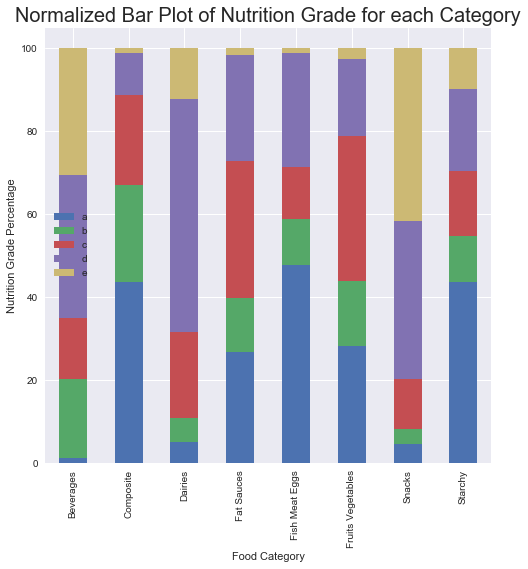

In [550]:
lettercounts =nutridata.groupby(['food_category','nutri-score_letter_CALCULATED']).count()['nutri-score_calculated']

plt.figure(figsize=(8,8))
ax=plt.gca()

lettercounts.unstack().div(lettercounts.unstack().sum(axis=1)/100,axis=0).plot.bar(ax=ax,stacked=True)
plt.legend(loc='center left')
plt.title("Normalized Bar Plot of Nutrition Grade for each Category",fontsize=20);
plt.xlabel("Food Category");
plt.ylabel("Nutrition Grade Percentage");

# Diet Study 



### Helper functions for Diet Study

In [7]:
def clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = False, langdetec = False, tokenize = False, stemming = False, lemmatizing = False, onlyEngStemmer = False, applyNounFilter = False):
    """function that appeals all cleaning methods depending of the booleans"""
    cleaned_data = pd.DataFrame()    
    cleaned_data[column_to_clean] = data[column_to_clean].copy()
    
    
    if langdetec:
        cleaned_data["languages"] = data[data[column_to_clean].notnull()][column_to_clean].apply(language_detection)
        #I found all the languages disponibles for stemming, and i map the corresponding name to the ISO_code found by langdetect.detect
        cleaned_data["languages"] = cleaned_data["languages"].map({"ar": "arabic", "da": "danish", "nl" : "dutch", "en": "english", "fi": "finnish", "fr": "french", "de": "german", \
                                  "hu": "hungarian", "it": "italian", "no": "norwegian", "ro": "romanian", "ru" : "russian", "es": "spanish", \
                                  "sv" :"swedish"})
        if saving:
            cleaned_data.to_pickle("processed_pickle/"+str(column_to_clean)+"/out_langdetect.pkl")
       
    #tokenize column_to_clean : --> stemming + lemmatization need list of tokens
    if tokenize:
        cleaned_data[column_to_clean] = tokenize_data(cleaned_data[column_to_clean], stop_words, tokenizer, applyNounFilter)
        if saving:
            cleaned_data.to_pickle("processed_pickle/"+str(column_to_clean)+"/out_token.pkl")
    else: 
        cleaned_data = pd.read_pickle("processed_pickle/"+str(column_to_clean)+"/out_token.pkl") 
    
    #stemm column_to_clean column according to the language used
    if stemming:
        #for stemming, langdetection as to be made previously
        if (not(langdetec or onlyEngStemmer)):
            lang_data = pd.read_pickle("processed_pickle/"+str(column_to_clean)+"/out_langdetect.pkl")
            cleaned_data["languages"] = lang_data["languages"].copy()
        
        cleaned_data = stemming_data(cleaned_data, column_to_clean, onlyEngStemmer)
        
        if saving:
            cleaned_data.to_pickle("processed_pickle/"+str(column_to_clean)+"/out_stem.pkl")  
            
    elif lemmatizing: 
        #lemmatizing only works well for english words
        cleaned_data = lemmatizing_data(cleaned_data, column_to_clean, wordnet_lemmatizer)
        if saving: 
            cleaned_data.to_pickle("processed_pickle/"+str(column_to_clean)+"/out_lem")    

    return cleaned_data

def filter_nountag(tokenlist_cell):
    """keep only NN : nouns, singular or mass and NNS : noun,plural and NNP : proper noun"""
    
    postag_cell = pos_tag(tokenlist_cell)
    postag_cell_filtered = [tag for tag in postag_cell if ((tag[1]=='NNS') or (tag[1] == 'NN') or (tag[1] == "NNP"))]
    tokenlist_cell = [tag[0] for tag in postag_cell_filtered]
    
    return tokenlist_cell

def tokenize_data(data_column, stop_words, tokenizer, applyNounFilter = False):
    """Clean data, i.e. 
        - lower each words in the cells of data_column
        - tokenize cells of data_column, i.e. from float type create list of string (token)
        - remove stopwords for the list of tokens for each cells of data_column
        - keep only tokens with tag = NN (noun), or NNS (noun, plural)
    """  
    data_column = data_column[data_column.notnull()].str.lower() \
        .apply(str) \
        .apply(tokenizer.tokenize) \
        .apply(lambda cell : [item for item in cell if item not in stop_words]) 
    if applyNounFilter:
        data_column = data_column[data_column.notnull()].apply(filter_nountag)
    
    return data_column

def language_detection(category_cell): 
    """take a cell containing a the string from unprocessed dataframe and detect the language"""
    tmp_cell = str()
    tmp_cell = category_cell
    
    #supress numbers in string
    tmp_cell = tmp_cell.replace('\d+', '')
    #supress punctuations
    tmp_cell = re.sub(r'[^\w\s]','', tmp_cell)
    #remove spaces in string
    tmp_cell = ''.join(tmp_cell.split())
    
    #check if the string contain only letters --> f**king 🍩 
    if tmp_cell.isalpha():
        language = detect(category_cell)
        return detect(category_cell)
    else: 
        return None

def stemming_data(df_lang, serie_tokenlist, onlyEngStemmer = False):
    """Take as argument : 
        - df_lang = dataframe containing a serie of tokenlist, and a serie "languages" of corresponding language
        - serie_tokenlist = string name of the serie of tokenlist to stem
    """
    for i in [1, 2]:
        for index, row in df_lang[df_lang[serie_tokenlist].notnull()].iterrows():
            
            if onlyEngStemmer: 
                stemmer = SnowballStemmer("english")
            else: 
                stemmer = SnowballStemmer(row["languages"])
                df_lang.iloc[index][serie_tokenlist] = [stemmer.stem(token) for token in row[serie_tokenlist]]
 
        
    return df_lang

def lemmatizing_data(df, serie_tokenlist, wordnet_lemmatizer):
    """lemmatize serie containing token_list
        - serie_tokenlist = string name of the serie of tokenlist to lemmatize
        - df = dataframe containing "serie_tokenlist" column
        """
    for index, row in df[df[serie_tokenlist].notnull()].iterrows():
        df.iloc[index][serie_tokenlist] =  [wordnet_lemmatizer.lemmatize(token, pos="n") for token in row[serie_tokenlist]]
        #if u lemmatize verbs --> pos = "-v"
    return df


## Cleaning "categories" field

We first clean the 'categories' field and save the result in pickle format.

### -> If column field has to be cleaned

The cell below aims to clean the "categories" field and save outputs of each steps of the cleaning in pickle format. 
* create a repository in processed_pickle which has the name of the column to clean, i.e. processed_pickle/categories/ is the repository in which pickles will be saved

In [8]:
saving = False
# note : Language detection is only needed for stemming, 
# and it is a very long run (~1h)

#StopWords and Tokenizer Object initialization
stop_words = set(stopwords.words("french")).union(set(stopwords.words("english"))) #will remove only english and french stopwords
tokenizer = RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
column_to_clean = "categories"
#language detection
langdetect_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, langdetec = True)
#tokenization
tok_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, tokenize = True, applyNounFilter = True)
#stemming --> good since it consider language
stem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, stemming = True)
#lemmatize --> not very good since it does not consider language (only good for english)
lem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, lemmatizing = True)

### -> If column field already cleaned and saved in pkl

In [9]:
column = "categories"
langdetect_data = pd.read_pickle("processed_pickle/"+str(column)+"/out_langdetect.pkl")
categories_tok = pd.read_pickle("processed_pickle/"+str(column)+"/out_token.pkl") 
categories_stem = pd.read_pickle("processed_pickle/"+str(column)+"/out_stem.pkl") 
categories_lem = pd.read_pickle("processed_pickle/"+str(column)+"/out_lem.pkl") 

In [10]:
categories_dict = categories_stem[categories_stem["categories"].notnull()]["categories"].explode().value_counts()
for word in categories_dict[categories_dict>500].index:
    print(word)

aliment
boisson
produit
snack
fruit
lait
fromag
plat
céréal
biscuit
bas
plant
food
sauc
viand
pomm
légum
dessert
végétal
pât
confitur
beverag
poisson
chocolat
product
yaourt
déjeun
lebensmittel
nectar
jus
conserv
pet
cereal
charcut
getrank
mat
pflanzlich
snacks
chip
fr
pain
orig
grain
huil
tartin
epic
grass
glac
franc
poulet
vin
confis
coqu
miel
ajout
milk
crem
soup
surgel
légumin
bonbon
volaill
san
bi
prépar
compot
filet
marmelad
tart
foi
jambons
salad
rillet
frut
sirop
oliv
sardin
thon
alimentair
cuit
jambon
roug
chocolats
sorbet
juic
élevag
steak
beb
cond
veget
terrin
pickl
spread
flocon
édulcor
tomat
barr
beurr
sauces
saumon
frais
meal
cream
vert
sus
meat
vegetal
beverages
chocol
pâtiss
viennois
riz
milch
yogurt
orang
sech
champignon
sandwich
chaud
brioch
dulc
caf
fraîch
charcuteri
dairi
galet
noiset
milchprodukt
quich
bread
noir
tea
mélang
gazeux
onde
crêp
gâteau
chee
lech
natur
viandes
vinaigres
multifruit
pur
moutard
emmental
enti
biscuits
fleur
aliments
verdur
amand
infus
groce

## Diet Dictionary for categories field

We create dictionary for each diets. They have a YES list and NO list. A product is considered part of the diet is it has at least ONE element in its YES list (if not empty) and NO element in its NO list (if not empty).

In [11]:
regimes = ['vegetarian', 'vegan', 'glutenfree', 'lactosefree', 'ketogenic', 'organic']

In [12]:
#Initialization needed to create a serie containing unauthorized items  for each of the diets
unauthorized_categories = pd.Series(index = regimes).rename('unauthorized_categories')

unauthorized_listnames_categories = ['categories_' + str(x) + '_NOlist' for x in regimes]
unauthorized_listnames_categories

#Initialization needed to create a serie containing authorized items for each of the diets
authorized_categories = pd.Series(index = regimes).rename('authorized_labelsen')

authorized_listnames_categories = ['categories_' + str(x) + '_YESlist' for x in regimes]
authorized_listnames_categories

['categories_vegetarian_YESlist',
 'categories_vegan_YESlist',
 'categories_glutenfree_YESlist',
 'categories_lactosefree_YESlist',
 'categories_ketogenic_YESlist',
 'categories_organic_YESlist']

In [13]:
#Vegetarian_NOlist = regimes(0)
categories_Vegetarian_NOlist = ['foi', 'sauc', 'steak', 'viand', 'viandes', 'meat', 'beef', 'poisson', 'charcut', 'charcuteries', 'charcuteri', 'poulet', 'poul', 'volaill', 'jambons', 'jambon', 'jam', 'rillet', 'sardin', 'thon', 'steak', 'saumon', 'salmon', 'escalop', 'dind', 'jam', \
                             'boudin', 'animal', 'cannard', 'porc', 'lasagn', 'cuiss', 'fish', 'crevet', 'fleisch', 'vach', 'chipolat', 'fisch', 'lardon', 'bacon', 'hareng', 'seafood', 'chicken', 'breb', 'bovin']
categories_Vegetarian_YESlist = []

#Lactosefree = regime(3)
categories_Lactosefree_NOlist = ['fromag', 'lait', 'yaourt', 'bi', 'écrem', 'cream', 'crem', 'glac', 'milk', 'milks', 'dairi', 'dair', 'dairies', 'beurr', 'milch', 'milchprodukt', 'chee', \
                                'cake', 'crêp', 'bread', 'gâteau' , 'lait', 'butter', 'butt', 'cooki', 'emmental', 'comt', 'camembert', 'margarin', 'kas', 'cheddar', 'yogurt', 'yogur', 'yogurts']
categories_Lactosefree_YESlist = []


#Vegan_NOlist = regimes(1)
categories_Vegan_NOlist = categories_Lactosefree_NOlist + \
                          categories_Vegetarian_NOlist + \
                         ['mayon', 'mayonnaises', 'mayonnaises', 'moutardes', 'mustard', 'egg', 'œuf']
categories_Vegan_YESlist = []

#Glutenfree = regime(2)
categories_Glutenfree_NOlist = ['pât', 'pasta', 'pâtiss', 'past', 'nouill', 'viennois', 'biscuit', 'biscuits', 'sauc', 'sauces', 'charcut', 'charcuteri', 'charcuteries', 'bread', 'crêp', 'gâteau', 'farin', 'farines', 'pizz', 'pizzas', 'cake', 'madelein', \
                                'brotaufstrich', 'brot', 'beignet', 'lasagn', 'raviol', 'blé', 'wheat', 'bi', 'pies', 'kuch', 'muffin', 'gaufr', 'gaufret', 'biscott', 'cooki', 'cook', 'brot']
categories_Glutenfree_YESlist = []


#Ketogenic = regimes(4)
categories_Ketogenic_NOlist = ['sucr', 'pomm', 'confitur', 'confiseries', 'confiseri', 'confis' ,'orang', 'nouill', 'semoul', 'sorbet', 'legumin', 'légumin', 'multifruit', 'potato', 'lait', 'bean', 'haricot', 'lentill', 'lentill', 'riz', 'pasta', \
                               'pasta', 'milk', 'milks', 'sirop', 'candi', 'jus', 'juic', 'tart', 'marmelad', 'snack', 'snacks', 'biscuit', 'pât', 'confitur', 'chocolat', 'chocolats', 'chocol', \
                               'nectar', 'nect', 'bread', 'chip', 'chips', 'pain', 'miel', 'bonbon', 'compot', 'pâtiss']
categories_Ketogenic_YESlist = categories_Lactosefree_NOlist + \
                               categories_Vegetarian_NOlist + \
                               ['végétal', 'grass', 'huil', 'grain', 'nut', 'tomato', 'tomat', 'oils', 'oil', 'moutardes', 'mustard', 'fat', 'mayon', 'mayonnaises', 'mayonnaises', \
                                'seed', 'gras']



#Organic = regimes(5)
categories_Organic_NOlist = []
categories_Organic_YESlist = []


categories_YESlists = [categories_Vegetarian_YESlist, categories_Vegan_YESlist, \
                      categories_Glutenfree_YESlist, categories_Lactosefree_YESlist, \
                      categories_Ketogenic_YESlist, categories_Organic_YESlist]

categories_NOlists = [categories_Vegetarian_NOlist, categories_Vegan_NOlist, \
                      categories_Glutenfree_NOlist, categories_Lactosefree_NOlist, \
                      categories_Ketogenic_NOlist, categories_Organic_NOlist]

## Cleaning labels_en field

The 'label_en' column is used to complete the diet attribution of products

In [14]:
saving = True
# note : Language detection is only needed for stemming, 
# and it is a very long run (~1h)

#StopWords and Tokenizer Object initialization
stop_words = set(stopwords.words("french")).union(set(stopwords.words("english"))) #will remove only english and french stopwords
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
column_to_clean = "labels_en"

#tokenization
tok_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving=True, tokenize=True)
#stemming --> good since it consider language
stem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving=True, stemming=True, onlyEngStemmer=True)


In [15]:
label_tok = pd.read_pickle("processed_pickle/labels_en/out_token.pkl")
label_stem = pd.read_pickle("processed_pickle/labels_en/out_stem.pkl")

## Diet Dictionary for labels_en field

The same methodology is used for obtaining diet information from the 'labels_en' column and completing our diet categorization

In [16]:
data[data["labels_en"].notnull()]["labels_en"].value_counts().head(50)

Organic                                                                            18264
Gluten-free                                                                        12392
Organic,EU Organic,fr:ab-agriculture-biologique                                     6804
Green Dot                                                                           6570
Vegetarian,Vegan                                                                    4911
Made in France                                                                      4903
No preservatives                                                                    3694
No colorings                                                                        2764
No added sugar                                                                      2224
Organic,EU Organic,FR-BIO-01                                                        2051
No colorings,No preservatives                                                       1775
Organic,EU Organic,FR

In [18]:
labelsen_dict = label_stem[label_stem["labels_en"].notnull()]["labels_en"].explode().value_counts()
for word in labelsen_dict[labelsen_dict > 1000].index:
    print(word)

organic
fr
free
agriculture
gluten
green
dot
made
bio
france
ab
biologique
vegetarian
vegan
preservatives
01
colorings
sugar
non
nutriscore
viande
french
added
low
oil
palm
sustainable
francaise
lactose
carbon
footprint
eco
fsc
öko
flavors
artificial
certified
grade
emballages
halal
fat
milk
française
pork
salt
germany
utz
high
quality
pure
natural
pdo
meat
pgi
labels
italy
society
gmos
fair
distributor
trade
lait
transformed
006
german
agricultural
additives
femmes
enceintes
déconseillé
001
kosher
msc
100
triman
francais
10
fishery
seafood
union
superior
nl
butter
bretagne
produced
bovine
reduced
farming
intermarché
sélection
porcine
medal
sans
ru
label
français
without
volaille
european
origine
mix
max
havelaar
belgium
spain
source
concours
fibres
cacao
gold
oko
colors
saveurs
007
eg
verordnung
agricole
ecocert
général
3
b
class


In [19]:
#Initialization needed to create a serie containing authorized items for each of the diets
authorized_labelsen = pd.Series(index = regimes).rename('authorized_labelsen')

authorized_listnames_labelsen = ['labelsen_' + str(x) + '_YESlist' for x in regimes]
authorized_listnames_labelsen

#Initialization needed to create a serie containing unauthorized items  for each of the diets
unauthorized_labelsen = pd.Series(index = regimes).rename('unauthorized_labelsen')

unauthorized_listnames_labelsen = ['labelsen_' + str(x) + '_NOlist' for x in regimes]
unauthorized_listnames_labelsen

['labelsen_vegetarian_NOlist',
 'labelsen_vegan_NOlist',
 'labelsen_glutenfree_NOlist',
 'labelsen_lactosefree_NOlist',
 'labelsen_ketogenic_NOlist',
 'labelsen_organic_NOlist']

In [20]:
#Organic = regimes(5)
labelsen_Organic_YESlist = ['organic', 'bio', 'biologique']
#Ketogenic = regimes(4)
labelsen_Ketogenic_YESlist = []

#Lactosefree = regime(3) #since lactose only appears as NO lactose
labelsen_Lactosefree_YESlist = ['lactose']

#Glutenfree = regime(2)
labelsen_Glutenfree_YESlist = ['gluten']

#Vegan_NOlist = regimes(1)
labelsen_Vegan_YESlist = ['vegan']

#Vegetarian_NOlist = regimes(0)
labelsen_Vegetarian_YESlist = ['vegetarian']

labelsen_YESlists = [labelsen_Vegetarian_YESlist, labelsen_Vegan_YESlist, labelsen_Glutenfree_YESlist, \
                    labelsen_Lactosefree_YESlist, labelsen_Ketogenic_YESlist, labelsen_Organic_YESlist]

## Diet series creation

We create the series representing possible the diet regimes of products

In [21]:
def find_diet(data_stem, column, regimes, YESlists = None, NOlists = None): 
    """Complete the series "diet" of data_stem by taking informations in data_stem[column]"""
    for  index, row in data_stem[data_stem[column].notnull()].iterrows():
        for token in row[column]:
            for counter, regime in enumerate(regimes):                
                
                if not(YESlists == None):
                    if ((token in YESlists[counter]) & (regime not in data_stem.loc[index, "diet"])):
                        data_stem.loc[index, "diet"] = data_stem.loc[index, "diet"] + [regime]
                        
                if not(NOlists == None): 
                    #remove the regime if it is in diet_series[index]
                    if ((token in NOlists[counter]) & (regime in data_stem.loc[index, "diet"])):
                        data_stem.loc[index, "diet"].remove(regime)
                        
    return data_stem                

In [22]:
#Initialize dataframe
cleaned_fields = pd.DataFrame()
cleaned_fields["categories"] = categories_stem["categories"].copy()
cleaned_fields["labels_en"] = label_stem["labels_en"].copy()
cleaned_fields["diet"]= [[]]*len(cleaned_fields)
#cleaned_fields["diet"] = cleaned_fields["diet"].apply(lambda x: x + ["flexitarism"])
cleaned_fields["diet"] =  [["flexitarism"]]*len(cleaned_fields)

The next cells have not already been runned due to extensive computational time, but it shows how the "diet" field will be computed.

In [ ]:
cleaned_fields = find_diet(cleaned_fields, "labels_en", regimes, YESlists=labelsen_YESlists)
cleaned_fields.to_pickle("processed_pickle/_diet/labelsen_analysed")
cleaned_fields = find_diet(cleaned_fields, "labels_en", regimes, YESlists=categories_YESlists, NOlists=categories_NOlists)
cleaned_fields.to_pickle("processed_pickle/_diet/labelsen_categories_analysed")
cleaned_fields[cleaned_fields["labels_en"].notnull()].head(50)

In [ ]:
cleaned_fields.to_pickle("processed_pickle/_diet/labelsen_analysed")